# ECE763 Project 03 (Final Course Project): Self-Supervised Learning

### Objectives

* Implemenet two self-supervised contrastive learning methods
* Compare the representaitons via SSL with supervised baseline

### How to submit your solutions

* Add your NCSU IDs (all team members if had) as the postfix of the notebook filename.
* `If you have a team, please clearly state who contribute to which part(s) of the project.`
* Submit two versions of your notebook, one is fully executed with all outputs (`Project_03_ViT_twu19_results.ipynb`), and the other with all outputs cleared (`Project_03_ViT_twu19_empty.ipynb`). We will re-run the latter and expect the results will be exactly the same as those in the former. 
* No late days

### Team Contributions (if applicable)

* 
*
*

### Overview

How to learn good representations from unlabeled data (e.g., imagery data)? First of all, this data still contains a lot of information from which we can learn: how are the images different from each other? What patterns are descriptive for certain images? Can we cluster the images? And so on. Methods for self-supervised learning try to learn as much as possible from the data alone, so it can quickly be finetuned for a specific classification task. 

The benefit of self-supervised learning is that a large dataset can often easily be obtained. For instance, if we want to train a vision model on semantic segmentation for autonomous driving, we can collect large amounts of data by simply installing a camera in a car, and driving through a city for an hour. In contrast, if we would want to do supervised learning, we would have to manually label all those images before training a model. This is extremely expensive, and would likely take a couple of months to manually label the same amount of data. Further, self-supervised learning can provide an alternative to transfer learning from models pretrained on ImageNet since we could pretrain a model on a specific dataset/situation, e.g. traffic scenarios for autonomous driving.

Within the last several years, a lot of new approaches have been proposed for self-supervised learning using images, that have resulted in great improvements over supervised models when few labels are available.

Check our lecture notes 18-19 and references therein.




## Let's first start with importing our standard libraries below

In [ ]:


## Standard libraries
import os
from copy import deepcopy
import json
import math
import random
import numpy as np 
import copy
import time

## Imports for plotting
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_theme()

## Progress bar
from tqdm.notebook import tqdm

## typing
from typing import (
    Any,
    Callable,
    Dict,
    List,
    Optional,
    Sequence,
    Set,
    Tuple,
    Type,
    Union,
)

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision.datasets import CIFAR10,STL10
from torchvision import transforms


# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: 
    !pip install --quiet pytorch-lightning>=1.6
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard


## Identify the system

In [ ]:
import platform
from mmengine.utils.dl_utils import collect_env
from pprint import pprint

print("=" * 40, "System Information", "=" * 40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

print("=" * 40, "Environment Information", "=" * 40)
my_env = collect_env()
pprint(my_env)

## General settings

In [ ]:


# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../checkpoints/ece763-proj_03"

# Setting the seed
pl.seed_everything(42)
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
# NUM_WORKERS = os.cpu_count()
NUM_WORKERS = len(os.sched_getaffinity(0))

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

# Get started with implementing SimCLR

It is a method of self-supervised `contrastive` learning. Contrastive learning is motivated by the question mentioned above: how are images different from each other? Specifically, contrastive learning methods train a model to cluster an image and its slightly augmented version in latent space, while the distance to other images should be maximized. A very recent and simple method for this is [SimCLR](https://arxiv.org/abs/2006.10029), which is visualized below (figure credit - [Ting Chen et al.](https://simclr.github.io/)).

<center width="100%"><img src="figures/simclr_contrastive_learning.png" width="500px"></center>

The general setup is that we are given a dataset of images without any labels, and want to train a model on this data such that it can quickly adapt to any image recognition task afterward. During each training iteration, we sample a batch of images as usual. For each image, we create two versions by applying data augmentation techniques like cropping, Gaussian noise, blurring, etc. An example of such is shown on the left with the image of the dog. We will go into the details and effects of the chosen augmentation techniques later. On those images, we apply a CNN like ResNet and obtain as output a 1D feature vector on which we apply a small MLP. The output features of the two augmented images are then trained to be close to each other, while all other images in that batch should be as different as possible. This way, the model has to learn to recognize the content of the image that remains unchanged under the data augmentations, such as objects which we usually care about in supervised tasks.

We will now implement this framework ourselves and discuss further details along the way. 

## Dataset

 We will use the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/), which, similarly to CIFAR10, contains images of 10 classes: `airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck`. However, the images have a higher resolution, namely $96\times 96$ pixels, and we are only provided with 500 labeled images per class. Additionally, we have a much larger set of $100,000$ unlabeled images which are similar to the training images but are sampled from a wider range of animals and vehicles. This makes the dataset ideal to showcase the benefits that self-supervised learning offers. 
 
 However, to reduce the computationally complexity, we will downscale the images back to $32\times 32$ pixels.  `Note: If you have sufficient GPU resources, you may try your implementation using` $96\times 96$.

Luckily, the STL10 dataset is provided through torchvision. Keep in mind, however, that since this dataset is relatively large and has a considerably higher resolution than CIFAR10, it requires more disk space (~3GB) and takes a bit of time to download. For our initial discussion of self-supervised learning and SimCLR, we will create two data loaders with our contrastive transformations above: the `unlabeled_data` will be used to train our model via contrastive learning, and `train_data_contrast` will be used as a validation set in contrastive learning.

### Data Augmentation for Contrastive Learning

We will start our exploration of contrastive learning by discussing the effect of different data augmentation techniques, and how we can implement an efficient data loader for such. To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice. This is implemented in the class `ContrastiveTransformations` below:

In [ ]:
class ContrastiveTransformations(object):
    
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views
        
    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

The contrastive learning framework can easily be extended to have more _positive_ examples by sampling more than two augmentations of the same image. However, the most efficient training is usually obtained by using only two.

Next, we can look at the specific augmentations we want to apply. The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR since it directly affects how the latent space is structured, and what patterns might be learned from the data. Let's first take a look at some of the most popular data augmentations (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="figures/simclr_data_augmentations.png" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

All of them can be used, but it turns out that two augmentations stand out in their importance: crop-and-resize, and color distortion. Interestingly, however, they only lead to strong performance if they have been used together as discussed by [Ting Chen et al.](https://arxiv.org/abs/2006.10029) in their SimCLR paper. When performing randomly cropping and resizing, we can distinguish between two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="figures/crop_views.svg" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>

While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in latent space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view. However, without color distortion, there is a loophole that the model can exploit, namely that different crops of the same image usually look very similar in color space. Consider the picture of the dog above. Simply from the color of the fur and the green color tone of the background, you can reason that two patches belong to the same image without actually recognizing the dog in the picture. In this case, the model might end up focusing only on the color histograms of the images, and ignore other more generalizable features. If, however, we distort the colors in the two patches randomly and independently of each other, the model cannot rely on this simple feature anymore. Hence, by combining random cropping and color distortions, the model can only match two patches by learning generalizable representations.



In [ ]:
# TODO data augmentaiton - [5 POINTS]
# Overall, for our experiments, we apply a set of 5 transformations following the original SimCLR setup: 
# random horizontal flip, 
# crop-and-resize, 
# color distortion, 
# random grayscale, 
# and gaussian blur. 
# In comparison to the [original implementation](https://github.com/google-research/simclr), 
# we reduce the effect of the color jitter slightly (0.5 instead of 0.8 for brightness, contrast, and saturation, and 0.1 instead of 0.2 for hue). 
# In our experiments, this setting obtained better performance and was faster and more stable to train. 
# If, for instance, the brightness scale highly varies in a dataset, the original settings can be more beneficial 
# since the model can't rely on this information anymore to distinguish between images.
# raise NotImplementedError
data_size: tuple[int, int] = (32, 32)

def get_random_resized_crop_transform(ratio_low: float = 3/4, ratio_high: float = 4/3):
    # the simCLR paper implemented a random scale between 0.08 & 1.0
    # the simCLR paper implemented a random aspect ratio between 3/4 & 4/3
    return transforms.RandomResizedCrop(size=data_size, scale=(0.08, 1.0), ratio=(3/4, 4/3))

def get_gaussian_blur_transform(sigma_low: float = 0.1, sigma_high: float = 2.0):
    # kernel size is 10% of width/height and we are setting the minimum value to be 3 in either direction
    kernel_size = (int(np.clip(int(data_size[0] * 0.1), 3, 65535)), int(np.clip(int(data_size[1] * 0.1), 3, 65535)))
    return transforms.GaussianBlur(kernel_size=kernel_size, sigma=(sigma_low, sigma_high))

contrast_transforms = transforms.Compose([
    get_random_resized_crop_transform(),
    transforms.RandomHorizontalFlip(p=0.5),
    # paper randomly applies color jitter with a probability of 0.8
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)]), p=0.8),
    # paper randomly applies grayscale with a probability of 0.2
    transforms.RandomGrayscale(p=0.2),
    # paper randomly applies gaussian blur with a probability of 0.5
    transforms.RandomApply(torch.nn.ModuleList([get_gaussian_blur_transform()]), p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [ ]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True, 
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True, 
                            transform=ContrastiveTransformations(contrast_transforms, n_views=2))

In [ ]:
# Downscale images to 32x32 directly in arrays to save RAM and data loading computation
def downscale_dataset(dataset):
    data = dataset.data
    num_imgs = data.shape[0]
    new_data = np.zeros((num_imgs, data.shape[1], 32, 32), dtype=data.dtype)
    for i in tqdm(range(0, num_imgs, 100)):
        new_data[i:i+100] = transforms.functional.resize(torch.from_numpy(data[i:i+100]).float(), size=[32, 32]).to(torch.uint8).numpy()
    dataset.data = new_data
    
downscale_dataset(unlabeled_data)
downscale_dataset(train_data_contrast)

Finally, before starting with our implementation of SimCLR, let's look at some example image pairs sampled with our augmentations:

In [ ]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(14,7))
plt.title('Augmented image examples of the STL10 dataset', fontsize=20)
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

We see the wide variety of our data augmentation, including randomly cropping, grayscaling, gaussian blur, and color distortion. Thus, it remains a challenging task for the model to match two, independently augmented patches of the same image.

## Part 1: SimCLR implementation

Using the data loader pipeline above, we can now implement SimCLR. At each iteration, we get for every image $x$ two differently augmented versions, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$. Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch. The encoder network is split into two parts: a base encoder network $f(\cdot)$, and a projection head $g(\cdot)$. The base network is usually a deep CNN as we have seen before, and is responsible for extracting a representation vector from the augmented data examples. In our experiments, we will use a very simple `BaseNetwork` architecture as $f(\cdot)$, and refer to the output as $f(\tilde{x}_i)=h_i$. The projection head $g(\cdot)$ maps the representation $h$ into a space where we apply the contrastive loss, i.e., compare similarities between vectors. It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer. Note that in the follow-up paper, [SimCLRv2](https://arxiv.org/abs/2006.10029), the authors mention that larger/wider MLPs can boost the performance considerably. This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset. The general setup is visualized below (figure credit - [Ting Chen et al.](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="figures/simclr_network_setup.svg" width="350px"></center>

After finishing the training with contrastive learning, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor. The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task. This is likely because the representations $z$ are trained to become invariant to many features like the color that can be important for downstream tasks. Thus, $g(\cdot)$ is only needed for the contrastive learning stage.

Let's first start by implementing a Base Network which will represent function $f(\cdot)$. Usually, you would use very large, powerful networks like a deep ResNet, but these are very expensive to train. To reduce the computational cost and make it possible to train the models with limited computong resources, we provide a very simple CNN here:

In [ ]:
class BaseNetwork(nn.Module):

    def __init__(self, num_input_channels, c_hid, output_dim):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - c_hid : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - output_dim : Dimensionality of the final latent representation
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            nn.BatchNorm2d(c_hid),
            nn.SiLU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_hid),
            nn.SiLU(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            nn.BatchNorm2d(2*c_hid),
            nn.SiLU(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*c_hid),
            nn.SiLU(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            nn.BatchNorm2d(2*c_hid),
            nn.SiLU(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, output_dim)
        )

    def forward(self, x):
        return self.net(x)

Now that the architecture is described, let's take a closer look at how we train the model. As mentioned before, we want to maximize the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$ in the figure above, while minimizing it to all other examples in the batch. SimCLR thereby applies the InfoNCE loss, originally proposed by [Aaron van den Oord et al.](https://arxiv.org/abs/1807.03748) for contrastive learning. In short, the InfoNCE loss compares the similarity of $z_i$ and $z_j$ to the similarity of $z_i$ to any other representation in the batch by performing a softmax over the similarity values. The loss can be formally written as:

$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$

The function $\text{sim}$ is a similarity metric, and the hyperparameter $\tau$ is called temperature determining how peaked the distribution is. Since many similarity metrics are bounded, the temperature parameter allows us to balance the influence of many dissimilar image patches versus one similar patch. The similarity metric that is used in SimCLR is cosine similarity, as defined below:

$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$

The maximum cosine similarity possible is $1$, while the minimum is $-1$. In general, we will see that the features of two different images will converge to a cosine similarity around zero since the minimum, $-1$, would require $z_i$ and $z_j$ to be in the exact opposite direction in all feature dimensions, which does not allow for great flexibility.

Finally, now that we have discussed all details, let's implement SimCLR below as a PyTorch Lightning module:

In [ ]:
def masked_logsumexp(arr: torch.Tensor) -> torch.Tensor:
    assert len(arr.shape) == 2
    assert arr.size(0) == arr.size(1), "Not a square matrix."
    sum_: torch.Tensor = torch.zeros(arr.size(0)).to(arr.device)
    for i in range(arr.size(0)):
        # the diagonal of the incoming arr matrix will be a square, where the diagonal is set to [0], so for each row there will be
        # an offset of 1 from e^0 = 1, so subtract 1 from the sum before taking the log
        sum_[i] = torch.log(torch.sum(torch.exp(arr[i])) - 1)

    return sum_
    
# just for testing
class SimCLR(nn.Module):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.lr = lr
        self.temperature = temperature
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        # last_input_dim_of_base_network = 2 * 16 * hidden_dim
        # output_dim = int(last_input_dim_of_base_network * 0.5) + last_input_dim_of_base_network
        output_dim = 4 * hidden_dim
        # Base model f(.)
        self.base_model = BaseNetwork(num_input_channels=3, c_hid=hidden_dim, output_dim=output_dim)
    
        # The MLP for g(.) consists of Linear->ReLU->Linear
        # paper states they use the same output dimension as the input dimension for the mlp portion
        self.mlp = nn.Sequential(
            # paper does not apply any bias in the linear dimensions
            nn.Linear(in_features=output_dim, out_features=output_dim, bias=False),
            # paper applies ReLU activation function
            nn.ReLU(),
            nn.Linear(in_features=output_dim, out_features=output_dim, bias=False),
        )

    def forward(self, x) -> tuple[torch.Tensor, torch.Tensor]:
        assert isinstance(x, (list, tuple)), f"input x is not a list nor tuple. Got '{type(x)}'."
        assert len(x) == 2, f"input x is not of length 2. Got '{len(x)}'."
        out0 = self.mlp(self.base_model(x[0]))
        out1 = self.mlp(self.base_model(x[1]))
        return out0, out1

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.max_epochs, eta_min=self.lr/50)

        return optimizer, lr_scheduler

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch  # we do not need the labels here
        # imgs is a list of length 2, where imgs[0][i] and imgs[1][i] are the positive pairs
        # imgs[0] will be of size, [Batch size, 2, height, width]
        # imgs[1] will be of size, [Batch size, 2, height, width]
        
        # encode images
        out = self.forward(imgs)
        # out is a list of length 2
        # out[0] will be of size, [Batch size, output dim]
        # out[1] will be of size, [Batch size, output dim]
        
        # TODO: Calculate the contrastive loss of SimCLR. Try to be as efficient as possible [20 POINTS]
        # Hint: if you add imgs into a batch where over dimension 0, you have [imgs[0],imgs[1]],
        # the positive pair for an image at position i is always at (i + batch_size) % (2 * batch_size)
        # Can you create a mask to find the positive element for each batch element?
        # raise NotImplementedError

        # interleave tensors so that the positive pairs are next to each other, e.g., indices (0, 1), (2, 3), (4, 5), etc... correspond to positive pairs
        out_cat = torch.zeros((out[0].size(0) * 2, out[0].size(1)))
        out_cat[::2] = out[0]
        out_cat[1::2] = out[1]
        batch_size = out_cat.size(0)
        # calculate cosine similarity between all output vectors
        cos_sim = F.cosine_similarity(out_cat[None, :, :], out_cat[:, None, :], dim=-1)
        # set all variances (diagonal) to 0 so that e^0 = 1 when taking the logsumexp
        cos_sim[torch.eye(batch_size).bool()] = 0

        targets = torch.arange(batch_size)
        # map targets from (0, 1, 2, 3, 4, 5, 6, 7) -> (1, 0, 3, 2, 5, 4, 7, 6) indicating which the target positive pair
        # add 1 to each position where mod(2) == 0, corresponding to each image's positive pair
        targets[::2] += 1
        # subtract 1 to each position where mod(2) == 1, correspondign to each image's positive pair
        targets[1::2] -= 1
        index = targets.reshape(batch_size, 1).long()
        positive_pairs_mask = torch.zeros(batch_size, batch_size).long()
        src = torch.ones(batch_size, batch_size).long()
        positive_pairs_mask = torch.scatter(positive_pairs_mask, 1, index, src)
        ppm_argmax = torch.argmax(positive_pairs_mask, dim=1)
        
        cos_sim /= self.temperature
        logsumexp_ = masked_logsumexp(cos_sim)
        cos_sim_ppm = cos_sim[torch.arange(len(ppm_argmax)), ppm_argmax]
        #
        loss = -cos_sim_ppm + logsumexp_
        loss = loss.mean()
        # pdb.set_trace()
        
        # concatenate the positive pairs results with the negative pairs results (where these have the positive pair masked out) to determine the number
        # of image pairs that ranked better in the similarity metric than the positive pair
        cos_sim_masked = torch.cat([cos_sim[torch.arange(len(ppm_argmax)), ppm_argmax][:, None], cos_sim.masked_fill(positive_pairs_mask.bool(), -9e15)], dim=-1)
        # determine the number of negative pairs that are ranked higher than the positive pair
        sim_argsort = torch.argsort(cos_sim_masked, dim=-1, descending=True).argmin(dim=-1)

        acc_top1 = (sim_argsort == 0).float().mean()
        acc_top5 = (sim_argsort < 5).float().mean()
        acc_mean_pos = 1 + sim_argsort.float().mean()
        # Log the loss and the top-1 and top-5 accuracy as how often the most similar image was the positive
        # self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        # self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        # self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())
        # self.log(mode + "_loss", loss)

        return loss, acc_top1, acc_top5, acc_mean_pos

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='val')
    


In [ ]:
from tqdm import tqdm

def train_one_epoch(model: nn.Module, optimizer, data_loader):
    loss: list[float] = []
    acc_top1: list[float] = []
    acc_top5: list[float] = []
    acc_mean_pos: list[float] = []
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        loss_, acc_top1_, acc_top5_, acc_mean_pos_ = model.info_nce_loss(batch)
        loss_.backward()
        optimizer.step()
        loss.append(float(loss_))
        acc_top1.append(float(acc_top1_))
        acc_top5.append(float(acc_top5_))
        acc_mean_pos.append(float(acc_mean_pos_))

    return loss, acc_top1, acc_top5, acc_mean_pos


def test_one_epoch(model: nn.Module, data_loader):
    loss: list[float] = []
    acc_top1: list[float] = []
    acc_top5: list[float] = []
    acc_mean_pos: list[float] = []
    for batch in tqdm(data_loader):
        loss_, acc_top1_, acc_top5_, acc_mean_pos_ = model.info_nce_loss(batch)
        loss.append(float(loss_))
        acc_top1.append(float(acc_top1_))
        acc_top5.append(float(acc_top5_))
        acc_mean_pos.append(float(acc_mean_pos_))

    return loss, acc_top1, acc_top5, acc_mean_pos

def train_model(model: nn.Module, optimizer, learning_rate_scheduler, train_loader, val_loader, test_val_epoch_interval: int = 1, max_epochs: int = 500):
    loss: dict[str, dict[int, float]] = {"train": {}, "val": {}}
    acc_top1: dict[str, dict[int, float]] = {"train": {}, "val": {}}
    acc_top5: dict[str, dict[int, float]] = {"train": {}, "val": {}}
    acc_mean_pos: dict[str, dict[int, float]] = {"train": {}, "val": {}}
    for epoch in tqdm(range(1, max_epochs + 1), "Epoch:"):
        loss_, acc_top1_, acc_top5_, acc_mean_pos_ = train_one_epoch(model, optimizer, train_loader)
        try:
            loss["train"][epoch] = np.mean(loss_.copy())
            acc_top1["train"][epoch] = np.mean(acc_top1_.copy())
            acc_top5["train"][epoch] = np.mean(acc_top5_.copy())
            acc_mean_pos["train"][epoch] = np.mean(acc_mean_pos_.copy())
        except Exception as e:
            print(f"Got {e}.")
            return loss_, acc_top1_, acc_top5_, acc_mean_pos_
        learning_rate_scheduler.step()

        print_val: bool = False
        if epoch % test_val_epoch_interval == 0:
            print_val = True
            print("Validating...")
            model.eval()
            with torch.no_grad():
                loss_, acc_top1_, acc_top5_, acc_mean_pos_ = test_one_epoch(model, val_loader)
                loss["val"][epoch] = np.mean(loss_.copy())
                acc_top1["val"][epoch] = np.mean(acc_top1_.copy())
                acc_top5["val"][epoch] = np.mean(acc_top5_.copy())
                acc_mean_pos["val"][epoch] = np.mean(acc_mean_pos_.copy())
                
            model.train()

        print(f"\nLoss:\n\t Training: {loss['train'][epoch]:.6f}")
        if print_val:
            print(f"\t Validation: {loss['val'][epoch]:.6f}")
        print(f"Accuracy_Top1:\n\t Training: {acc_top1['train'][epoch] * 100:.2f}%")
        if print_val:
            print(f"\t Validation: {acc_top1['val'][epoch] * 100:.2f}%")
        print(f"Accuracy_Top5:\n\t Training: {acc_top5['train'][epoch] * 100:.2f}%")
        if print_val:
            print(f"\t Validation: {acc_top5['val'][epoch] * 100:.2f}%")
        print(f"Accuracy_Mean_Pos:\n\t Training: {acc_mean_pos['train'][epoch]:.2f}%")
        if print_val:
            print(f"\t Validation: {acc_mean_pos['val'][epoch]:.2f}%")

    return loss, acc_top1, acc_top5, acc_mean_pos

In [ ]:
run_nn_module: bool = False
if run_nn_module:
    batch_size = 128

    train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True, 
                                   drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False, 
                                 drop_last=False, pin_memory=True, num_workers=NUM_WORKERS,persistent_workers=True)

    hidden_dim = 64
    lr = 5e-4
    temperature = 0.07
    weight_decay = 1e-4
    max_epochs=10
    simclr = SimCLR(hidden_dim, lr, temperature, weight_decay, max_epochs)
    optimizer, lr_scheduler = simclr.configure_optimizers()
    
    loss, acc_top1, acc_top5, acc_mean_pos = train_model(simclr, optimizer, lr_scheduler, train_loader, val_loader, max_epochs=max_epochs)

In [ ]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # TODO: Setup the Base Network [5 POINTS]
        # raise NotImplementedError

        # last_input_dim_of_base_network = 2 * 16 * hidden_dim
        # output_dim = int(last_input_dim_of_base_network * 0.5) + last_input_dim_of_base_network
        output_dim = 4 * hidden_dim
        # Base model f(.)
        self.base_model = BaseNetwork(num_input_channels=3, c_hid=hidden_dim, output_dim=output_dim)
    
        # The MLP for g(.) consists of Linear->ReLU->Linear
        # paper states they use the same output dimension as the input dimension for the mlp portion
        self.mlp = nn.Sequential(
            # paper does not apply any bias in the linear dimensions
            nn.Linear(in_features=output_dim, out_features=output_dim, bias=False),
            # paper applies ReLU activation function
            nn.ReLU(),
            nn.Linear(in_features=output_dim, out_features=output_dim, bias=False),
        )

    def forward(self, x) -> tuple[torch.Tensor, torch.Tensor]:
        assert isinstance(x, (list, tuple)), f"input x is not a list nor tuple. Got '{type(x)}'."
        assert len(x) == 2, f"input x is not of length 2. Got '{len(x)}'."
        out0 = self.mlp(self.base_model(x[0]))
        out1 = self.mlp(self.base_model(x[1]))
        return out0, out1

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]
    
    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch  # we do not need the labels here
        # imgs is a list of length 2, where imgs[0][i] and imgs[1][i] are the positive pairs
        # imgs[0] will be of size, [Batch size, 2, height, width]
        # imgs[1] will be of size, [Batch size, 2, height, width]
        
        # encode images
        out = self.forward(imgs)
        # out is a list of length 2
        # out[0] will be of size, [Batch size, output dim]
        # out[1] will be of size, [Batch size, output dim]
        
        # TODO: Calculate the contrastive loss of SimCLR. Try to be as efficient as possible [20 POINTS]
        # Hint: if you add imgs into a batch where over dimension 0, you have [imgs[0],imgs[1]],
        # the positive pair for an image at position i is always at (i + batch_size) % (2 * batch_size)
        # Can you create a mask to find the positive element for each batch element?
        # raise NotImplementedError

        # interleave tensors so that the positive pairs are next to each other, e.g., indices (0, 1), (2, 3), (4, 5), etc... correspond to positive pairs
        out_cat = torch.zeros((out[0].size(0) * 2, out[0].size(1)))
        out_cat[::2] = out[0]
        out_cat[1::2] = out[1]
        batch_size = out_cat.size(0)
        # calculate cosine similarity between all output vectors
        cos_sim = F.cosine_similarity(out_cat[None, :, :], out_cat[:, None, :], dim=-1)
        cos_sim = F.cosine_similarity(out_cat[None, :, :], out_cat[:, None, :], dim=-1)
        # set all variances (diagonal) to -inf so that the sigmoid activation function will set them to 1
        cos_sim[torch.eye(batch_size).bool()] = 0

        targets = torch.arange(batch_size)
        # map targets from (0, 1, 2, 3, 4, 5, 6, 7) -> (1, 0, 3, 2, 5, 4, 7, 6) indicating which the target positive pair
        # add 1 to each position where mod(2) == 0, corresponding to each image's positive pair
        targets[::2] += 1
        # subtract 1 to each position where mod(2) == 1, correspondign to each image's positive pair
        targets[1::2] -= 1
        index = targets.reshape(batch_size, 1).long()
        positive_pairs_mask = torch.zeros(batch_size, batch_size).long()
        src = torch.ones(batch_size, batch_size).long()
        positive_pairs_mask = torch.scatter(positive_pairs_mask, 1, index, src)
        ppm_argmax = torch.argmax(positive_pairs_mask, dim=1)
        
        cos_sim /= self.hparams.temperature
        logsumexp_ = masked_logsumexp(cos_sim)
        cos_sim_ppm = cos_sim[torch.arange(len(ppm_argmax)), ppm_argmax]
        #
        loss = -cos_sim_ppm + logsumexp_
        loss = loss.mean()
        
        # concatenate the positive pairs results with the negative pairs results (where these have the positive pair masked out) to determine the number
        # of image pairs that ranked better in the similarity metric than the positive pair
        cos_sim_masked = torch.cat([cos_sim[torch.arange(len(ppm_argmax)), ppm_argmax][:, None], cos_sim.masked_fill(positive_pairs_mask.bool(), -9e15)], dim=-1)
        # determine the number of negative pairs that are ranked higher than the positive pair
        sim_argsort = torch.argsort(cos_sim_masked, dim=-1, descending=True).argmin(dim=-1)
        
        # Log the loss and the top-1 and top-5 accuracy as how often the most similar image was the positive
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())
        self.log(mode + "_loss", loss)

        return loss

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

### Training

Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model. We will use the same training function setup as usual. For saving the best model checkpoint, we track the metric `val_acc_top5`, which describes how often the correct image patch is within the top-5 most similar examples in the batch. This is usually less noisy than the top-1 metric, making it a better metric to choose the best model from.

In [ ]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')],
                         check_val_every_n_epoch=5)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True, 
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False, 
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS,persistent_workers=True)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

A common observation in contrastive learning is that the larger the batch size, the better the models perform. A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients, but a batch size of 256 is sufficient here. Again, for a first run, you can use 10 epochs, but try to increase the number of epochs for a final run.

In [ ]:
simclr_model = train_simclr(batch_size=256, 
                            hidden_dim=128, 
                            lr=5e-4, 
                            temperature=0.07, 
                            weight_decay=1e-4, 
                            max_epochs=10)

To get an intuition of how training with contrastive learning behaves, we can take a look at the TensorBoard below:

In [ ]:
%tensorboard --logdir ../checkpoints/ece763-proj_03/SimCLR/ --port 6006

In your report, show the top-1 and top-5 accuracy validation curves. Discuss the overall performance and the training speed. Is the model already converged? What does the final performance of the model imply about the learned feature space?

The training speed appears quite quick with regards to the number of epochs it takes until the training appears to begin to converge/overfit to the data. We can see from the training curve that the model approaches an accuracy ~100% fairly quickly in both the top 1 and top 5 accuracies. We notice that the training loss is still quite stochastic and decreasing, while the validation loss is also still decreasing. This begs the thought that the model still has room to learn after only its 10 epochs of training. The validation accuracies show good performance as well. The final performance of the model may imply that the learned feature space is doing well at projecting similar feature vectors to the same neighorhood while learning to increase the between-class variance of other image types to their corresponding neigborhoods. It would be interesting to train the model for more epochs, however, the training takes ~13 minutes per epoch, so it is quite intensive and we would have to go back and optimize performance of the model.

We also see from the below plots that by the time we do our first validation loop, we have nearly 100% validation accuracy. Since the validation accuracy has not necessarily gone out of sync with the training accuracy, it appears to be fit well. However, a training accuracy of 100% does continue to indicate overfitting.

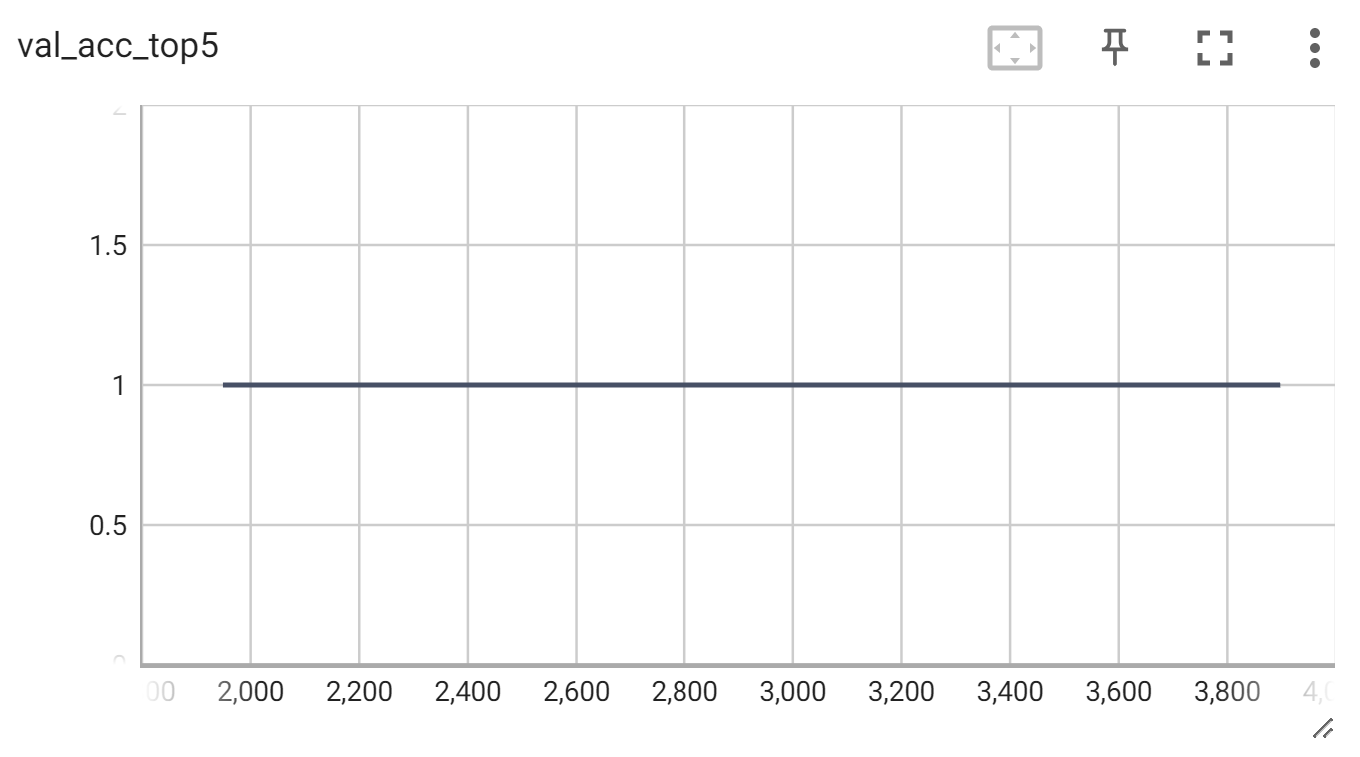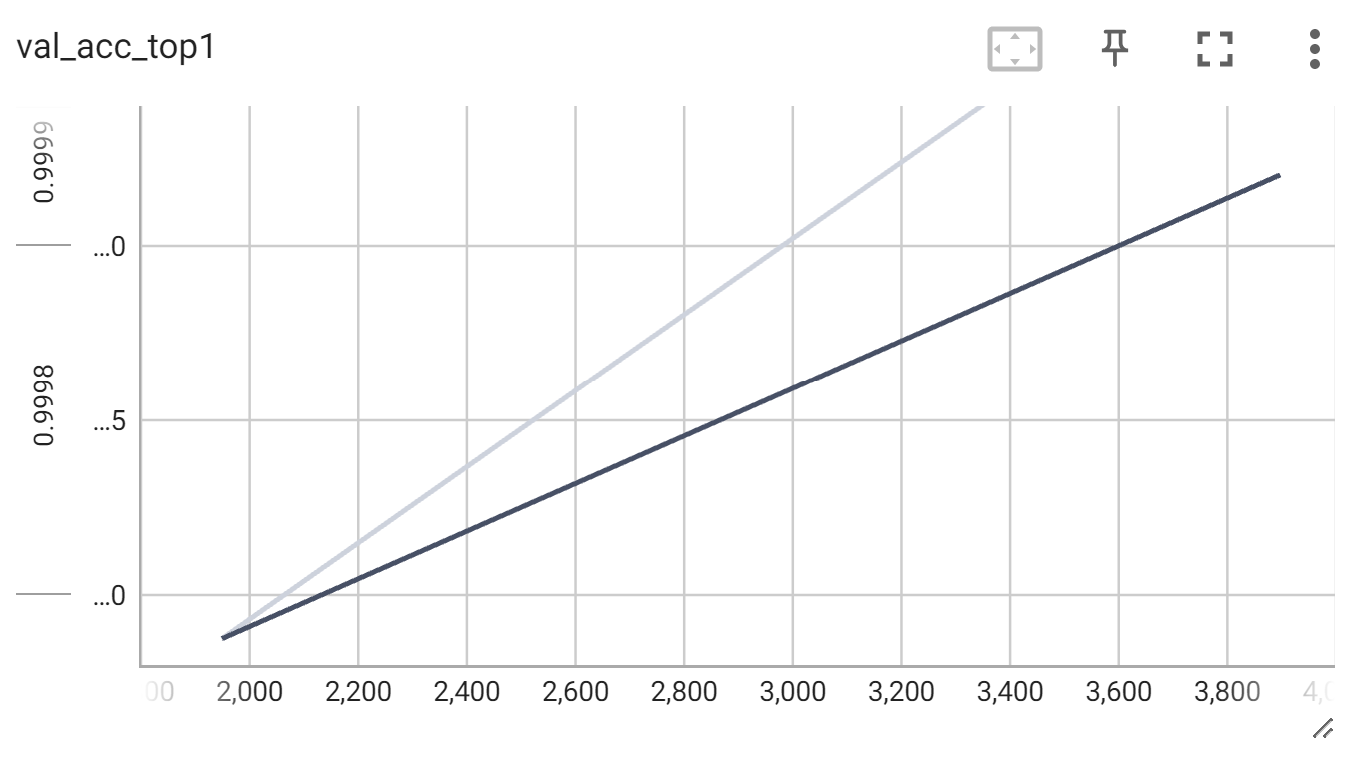

## Part 2: Logistic Regression

After we have trained our model via contrastive learning, we can deploy it on downstream tasks and see how well it performs with little data. A common setup, which also verifies whether the model has learned generalized representations, is to perform Logistic Regression on the features. In other words, we learn a single, linear layer that maps the representations to a class prediction. Since the base network $f(\cdot)$ is not changed during the training process, the model can only perform well if the representations of $h$ describe all features that might be necessary for the task. Further, we do not have to worry too much about overfitting since we have very few parameters that are trained. Hence, we might expect that the model can perform well even with very little data.

First, let's implement a simple Logistic Regression setup for which we assume that the images already have been encoded in their feature vectors. If very little data is available, it might be beneficial to dynamically encode the images during training so that we can also apply data augmentations. However, the way we implement it here is much more efficient and can be trained within a few seconds. Further, using data augmentations did not show any significant gain in this simple setup.

In [ ]:
from sklearn.metrics import accuracy_score

class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        # Initialize logistic regression model        
        self.model = nn.Linear(feature_dim, num_classes)
        self.criterion = nn.CrossEntropyLoss()
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                                      milestones=[int(self.hparams.max_epochs*0.6), 
                                                                  int(self.hparams.max_epochs*0.8)], 
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        # # TODO: Calculate classification loss for logistic regression model [5 POINTS]
        # raise NotImplementedError
        features, labels = batch
        logits = self.model(features)
        acc = accuracy_score(labels.detach().cpu(), torch.argmax(logits, dim=1).detach().cpu())

        # pdb.set_trace()
        loss = self.criterion(logits, labels.long())

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

The data we use is the training and test set of STL10. The training contains 500 images per class, while the test set has 800 images per class.

In [ ]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)
downscale_dataset(train_img_data)
downscale_dataset(test_img_data)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Next, we implement a small function to encode all images in our datasets. The output representations are then used as inputs to the Logistic Regression model.

In [ ]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # # TODO: Obtain the feature representation for all images in the dataset [5 POINTS]
    # raise NotImplementedError
    # network = deepcopy(model.encoder)
    # network.eval()
    # network.to(device)

    model.eval()
    model.to(device)
    # Encode all images
    labels: list[int] = []
    feats: list[torch.Tensor] = []
    for img, label in dataset:
        img = img.to(device)
        feat = model.mlp(model.base_model(img.unsqueeze(0)))
        labels.append(label)
        feats.append(feat)

    # pdb.set_trace()
    labels = torch.Tensor(labels)
    # labels = torch.cat(labels, dim=0)
    feats = torch.cat(feats, dim=0)
    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    # Return a new dataset with the image features and labels
    return data.TensorDataset(feats.to(torch.device("cpu")), labels)

Let's apply the function to both training and test set below.

In [ ]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

Finally, we can write a training function as usual. We evaluate the model on the test set every 10 epochs to allow early stopping, but the low frequency of the validation ensures that we do not overfit too much on the test set.

In [ ]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        enable_progress_bar=False,
        check_val_every_n_epoch=10,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True, 
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False, 
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

Despite the training dataset of STL10 already only having 500 labeled images per class, we will perform experiments with even smaller datasets. Specifically, we train a Logistic Regression model for datasets with only 10, 20, 50, 100, 200, and all 500 examples per class. This gives us an intuition on how well the representations learned by contrastive learning can be transfered to a image recognition task like this classification. First, let's define a function to create the intended sub-datasets from the full training set:

In [ ]:
def get_smaller_dataset(original_dataset, num_imgs_per_label: int, n_labels: int):
    # # TODO: Return dataset with the first N images per label [5 POINTS]
    # raise NotImplementedError
    def check_n_imgs_stored(img_dict: dict[int, list[torch.Tensor]]) -> bool:
        if len(img_dict.keys()) != n_labels:
            return False
        for val in list(img_dict.values()):
            if len(val) < num_imgs_per_label:
                return False

        return True
        
    imgs: dict[int, list[torch.Tensor]] = {}
    # img will be size [features], label will simply be an tensor int
    for img, label in original_dataset:
        if check_n_imgs_stored(imgs):
            break
        label = int(label)
        imgs.setdefault(label, [])
        label_img_cnt = len(imgs[label])
        if label_img_cnt < num_imgs_per_label:
            imgs[label].append(img)
    # for img, label in original_dataset:
    #     if check_n_imgs_stored(imgs):
    #         break
    #     unique_labels, indices, counts = torch.unique(label, return_inverse=True, return_counts=True)
    #     pdb.set_trace()
    #     for unique_label, index, count in zip(unique_labels, indices, counts):
    #         img.setdefault(unique_label, [])
    #         label_img_cnt = len(img[unique_label])
    #         if label_img_cnt < num_imgs_per_label:
    #             n_imgs_to_add = num_imgs_per_label - label_img_cnt
    #             if count > n_imgs_to_add:
    #                 index = index[:n_imgs_to_add]
    #             imgs[unique_label].extend([img[i] for i in index])

    labels = []
    for key, val in imgs.items():
        labels.extend([key] * len(val))
    labels = torch.Tensor(labels)
    imgs_cat: torch.Tensor = None
    for tensors in list(imgs.values()):
        cat_tensors = torch.cat([img_[None, :] for img_ in tensors], dim=0)
        if imgs_cat is None:
            imgs_cat = cat_tensors.clone()
        else:
            imgs_cat = torch.cat([imgs_cat, cat_tensors], dim=0)
    new_dataset = data.TensorDataset(imgs_cat, labels)
    
    return new_dataset

Next, let's run all models. Despite us training 6 models, this cell could be run within a minute or two without the pretrained models. 

In [ ]:
# # TODO: Run the logistic regression on datasets of 10, 20, 50, 100, 200, and 500 labeled examples [5 POINTS]
# raise NotImplementedError
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    train_feats_simclr_reduced = get_smaller_dataset(train_feats_simclr, num_imgs_per_label, 10)
    test_feats_simclr_reduced = get_smaller_dataset(test_feats_simclr, num_imgs_per_label, 10)
    model, small_set_results = train_logreg(
        batch_size=int(np.clip(256, 0, min((len(train_feats_simclr_reduced), len(test_feats_simclr_reduced))))),
        train_feats_data=train_feats_simclr_reduced,
        test_feats_data=test_feats_simclr_reduced,
        model_suffix=f"--n_imgs_per_label-{num_imgs_per_label}",
        feature_dim=4 * 128,
        num_classes=10,
        lr=5e-4,
        weight_decay=1e-4,
    )
    results[num_imgs_per_label] = small_set_results

Finally, let's plot the results.

In [ ]:
# Plot the results

dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    dataset_sizes,
    test_scores,
    "--",
    color="#000",
    marker="*",
    markeredgecolor="#000",
    markerfacecolor="y",
    markersize=16,
)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f"Test accuracy for {k:3d} images per label: {100*score:4.2f}%")
    
    
# We should observe performance similar 
# Test accuracy for  10 images per label: 40.09%
# Test accuracy for  20 images per label: 43.75%
# Test accuracy for  50 images per label: 48.66%
# Test accuracy for 100 images per label: 52.79%
# Test accuracy for 200 images per label: 55.26%
# Test accuracy for 500 images per label: 58.28%

TODO: [5 POINTS] Discuss the overall performance as well as the trend you see in the plot. Where do you see the biggest jump in performance? Is the performance already saturating?

We can see that the test accuracies of the differing reduced datasets aligns well with what we were expecting of the accuracies. We can see that as we introduce more images into our testing dataset, we are getting a better accuracy. This may be a consequence of the central limit theorem, indicating that as we introduce more images in our test dataset, we are approaching the true distribution of our datset and seeing the performance of our self-supervised pre-trained network on a more unbiased dataset. Since we trained our initial self-supervised model on our entire training dataset, which is 5000 images, and we are only training the logistic regression portion on much smaller datasets, we can assume that the logistic regression training portion does not have ample samples to learn its own feature representations to the true labels from the latent space of the self-supervised model. As we add more data for our logistic regression model to learn its significantly smaller linear network on the true labels, we get better performance, which aligns with what we think would happen. We see th biggest jump in performance once we start training with more than 50 images per class, taking into consideration the fact that we have 10 classes that we are aiming to properly distinguish between and some state-of-the-art networks such as ImageNet & AlexNet included ~1,000 images per class, we can safely assume we are not providing the network with enough samples to suitably learn from (even when we initially trained the self-supervised model and the point of a self-supervised model is to leverage large amounts of unlabeled data, so in practice we would probably train our self-supervised model on much more imagery before fine-tuning a multi-layer percpetron layer to the true target classes from labeled data). Just from looking at the jump from 200 images to 500 images used for training, an even greater jump than the x2 jumps in number of images per class that we were using in previous training iterations, we can see that the accuracy is beginning to slow down in performance improvement. This may be indicative of saturation of training this logistic regression model from the pre-trained self-supervised model backbone, but again we digress to the idea that our original self-supervised model was not trained long enough nor with a suitable number of images to utilize for trying to appropriately separate 10 distinct classes.

## Part 3: Baseline

As a baseline to our results above, we will train the BaseNetwork with random initialization on the labeled training set of STL10. The results will give us an indication of the advantages that contrastive learning on unlabeled data has compared to using only supervised training. First, let's implement it below.

In [ ]:
class Baseline(pl.LightningModule):

    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Initialize a base network
        self.model = BaseNetwork(num_input_channels=3, c_hid=48, output_dim=num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                                      milestones=[int(self.hparams.max_epochs*0.7), 
                                                                  int(self.hparams.max_epochs*0.9)], 
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        # # TODO: Calculate classification loss and accuracy [5 points]
        # raise NotImplementedError
        imgs, targets = batch
        logits = self.model(imgs)
        loss = self.criterion(logits, targets)
        acc = accuracy_score(targets.detach().cpu(), torch.argmax(logits, dim=1).detach().cpu())
        
        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

It is clear that the ResNet easily overfits on the training data since its parameter count is more than 1000 times larger than the dataset size. To make the comparison to the contrastive learning models fair, we apply data augmentations similar to the ones we used before: horizontal flip, crop-and-resize, grayscale, and gaussian blur. Color distortions as before are not used because the color distribution of an image showed to be an important feature for the classification. Hence, we observed no noticeable performance gains when adding color distortions to the set of augmentations. Similarly, we restrict the resizing operation before cropping to the max. 125% of its original resolution, instead of 1250% as done in SimCLR. This is because, for classification, the model needs to recognize the full object, while in contrastive learning, we only want to check whether two patches belong to the same image/object. Hence, the chosen augmentations below are overall weaker than in the contrastive learning case.

In [ ]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                       ])

train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True,
                           transform=train_transforms)
downscale_dataset(train_img_aug_data)

The training function for the BaseNetwork is almost identical to the Logistic Regression setup. Note that we allow the BaseNetwork to perform validation every 2 epochs to also check whether the model overfits strongly in the first iterations or not.

In [ ]:
def train_baseline(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        enable_progress_bar=False,
        check_val_every_n_epoch=2,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_img_aug_data, batch_size=batch_size, shuffle=True, 
                                   drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    test_loader = data.DataLoader(test_img_data, batch_size=batch_size, shuffle=False, 
                                  drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = Baseline.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42) # To be reproducable
        model = Baseline(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = Baseline.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    val_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}

    return model, result

Finally, let's train the model and check its results. For a first run, use 10 epochs, but to obtain final results, try to train the model on more epochs.

In [ ]:
baseline_model, baseline_result = train_baseline(batch_size=64,
                                               num_classes=10,
                                               lr=1e-3,
                                               weight_decay=2e-4,
                                               max_epochs=10)

In [ ]:
print(f"Accuracy on training set: {baseline_result['train']:.2%}")
print(f"Accuracy on test set: {baseline_result['test']:.2%}")

# We should observe performance similar to 
# Accuracy on training set: 67.03%
# Accuracy on test set: 60.29%

In [ ]:
%tensorboard --logdir ../checkpoints/ece763-proj_03/ResNet/ --port 6010

TODO: [5 POINTS] Discuss the results you have obtained from this baseline and compare it to the logistic regression model in Part 2. What do you see? What do the results imply?

The baseline model, trained with the same number of epochs, but a higher learning rate and weight decay, performs quite similarly to the logistic regression model in Part 2. It does not seem overfit to the data, indicative of the training results vs test results. This was trained much quicker than first training the self-supervised model and then training the logistic regression model, however it is important to note that the bulk of the training time was due to the self-supervised model. However, the results imply that training the baseline, that is trained solely on the same labeled data we treated as unlabeled data for the self-supervised model, is performing at the same rate as that of our self-supervised model + logistic regression model, when the logistic regression model was trained on a much smaller sample of labeled data. This indicates the power of a self-supervised model, that we are able to leverage large amounts of unlabeled data on the back-end and then fine-tune it on a smaller dataset on the front-end and get similar results to a model trained with a loss using the target labels.

## Summary of SimCLR

We have discussed self-supervised contrastive learning and implemented SimCLR as an example method. We have applied it to the STL10 dataset and showed that it can learn generalizable representations that we can use to train simple classification models. Besides the discussed hyperparameters, the size of the model seems to be important in contrastive learning as well. If a lot of unlabeled data is available, larger models can achieve much stronger results and come close to their supervised baselines. Further, there are also approaches for combining contrastive and supervised learning, leading to performance gains beyond supervision (see [Khosla et al.](https://arxiv.org/abs/2004.11362)). 


# Explore Another SSL Method

Moreover, contrastive learning is not the only approach to self-supervised learning that has come up in the last two years and showed great results. Other methods include distillation-based methods like [BYOL](https://arxiv.org/abs/2006.07733), [SimSiam](https://arxiv.org/abs/2011.10566) and redundancy reduction techniques like [Barlow Twins](https://arxiv.org/abs/2103.03230). There is a lot more to explore in the self-supervised domain as briefly discssed in our lecture.


Implement `BYOL` or `SimSiam` or `BarlowTwins` to replace the SimCLR in Part 1 above, and re-do the experiments in Part 1 and Part 2.  With your new SSL method, compare with SimCLR and the baseline in Part 3. 

In [ ]:
class BarlowTwins(pl.LightningModule):

    def __init__(self, hidden_dim, lr, weight_decay, lambda_: float, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()

        # last_input_dim_of_base_network = 2 * 16 * hidden_dim
        # output_dim = int(last_input_dim_of_base_network * 0.5) + last_input_dim_of_base_network
        output_dim = 4 * hidden_dim
        self.base_model = BaseNetwork(num_input_channels=3, c_hid=hidden_dim, output_dim=output_dim)

        self.decoder = nn.Sequential(
            nn.Linear(in_features=output_dim, out_features=output_dim, bias=False),
            nn.ReLU(),
            nn.Linear(in_features=output_dim, out_features=output_dim, bias=False),
        )
    

    def forward(self, x) -> tuple[torch.Tensor, torch.Tensor]:
        assert isinstance(x, (list, tuple)), f"input x is not a list nor tuple. Got '{type(x)}'."
        assert len(x) == 2, f"input x is not of length 2. Got '{len(x)}'."
        out0 = self.decoder(self.base_model(x[0]))
        out1 = self.decoder(self.base_model(x[1]))
        return out0, out1

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def compute_the_loss(self, batch, mode="train"):
        imgs, _ = batch  # we do not need the labels here
        # imgs is a list of length 2, where imgs[0][i] and imgs[1][i] are the positive pairs
        out0, out1 = self(imgs)
        # TODO: Calculate the contrastive loss of SimCLR. Try to be as efficient as possible [20 POINTS]

        # normalize representation along the batch dimension
        out0 = torch.divide(torch.subtract(out0, out0.mean(0)), out0.std(0))
        out1 = torch.divide(torch.subtract(out1, out1.mean(0)), out1.std(0))

        # calculate cross-correlation matrix
        cc_mat = torch.divide(torch.matmul(out0.T, out1), out0.size(0))

        # loss
        cc_diff = torch.subtract(cc_mat, torch.eye(cc_mat.size(0)).to(cc_mat.device)).pow(2)
        
        # multiply off-diagonal elements of the cross-correlation difference matrix by some lambda
        off_diagonal_lambda = torch.ones(cc_mat.shape).to(cc_mat.device) * self.hparams.lambda_
        off_diagonal_lambda[torch.eye(cc_mat.size(0)).bool()] = 1
        cc_off_diagonal_mult = torch.multiply(cc_diff, off_diagonal_lambda)
        loss = cc_off_diagonal_mult.sum()

        # positive pairs mask
        positive_pairs_mask = torch.eye(cc_mat.size(0))
        ppm_argmax = torch.argmax(positive_pairs_mask, dim=1)
        cc_mat_masked = torch.cat([cc_mat[torch.arange(len(ppm_argmax)), ppm_argmax][:, None], cc_mat.masked_fill(positive_pairs_mask.bool().to(cc_mat.device), -9e15)], dim=-1)
        sim_argsort = torch.argsort(cc_mat_masked, dim=-1, descending=True).argmin(dim=-1)

        # Log the loss and the top-1 and top-5 accuracy as how often the most similar image was the positive
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())
        self.log(mode + "_loss", loss)
        return loss

    def training_step(self, batch, batch_idx):
        return self.compute_the_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.compute_the_loss(batch, mode="val")

In [ ]:
# # TODO: re-do experiments in Part 2 and Part 2 using your new Another SSL [5 POINTS]
# raise NotImplementedError

In [ ]:
def train_barlowtwins(batch_size, model_name: str = "BarlowTwins", max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_name),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')],
                         check_val_every_n_epoch=5)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f'{model_name}.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = BarlowTwins.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True, 
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False, 
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS,persistent_workers=True)
        pl.seed_everything(42) # To be reproducable
        model = BarlowTwins(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = BarlowTwins.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [ ]:
barlowtwins_model = train_barlowtwins(batch_size=256, 
                                      hidden_dim=128, 
                                      lr=5e-4,  # paper set this to 0.002, but want to keep it to 5e-4 for comparison purposes
                                      weight_decay=1e-4,  # paper set this to 10e-6, but want to keep it as 1e-4 for comparison purposes
                                      lambda_=0.005,  # best result for top-1 accuracy from paper
                                      max_epochs=10)

In [ ]:
%tensorboard --logdir ../checkpoints/ece763-proj_03/BarlowTwins/ --port 6011

We can see that our additional self-supervised learning model, BarlowTwins, is also able to perform well given unlabeled data. It appears to be able to learn sufficiently given the amount of unlabeled data, with regards to comparison to the previous self-supervised model as, again, in practice we would most likely have a much larger amount of unlabeled data to leverage in our self-supervised model training.

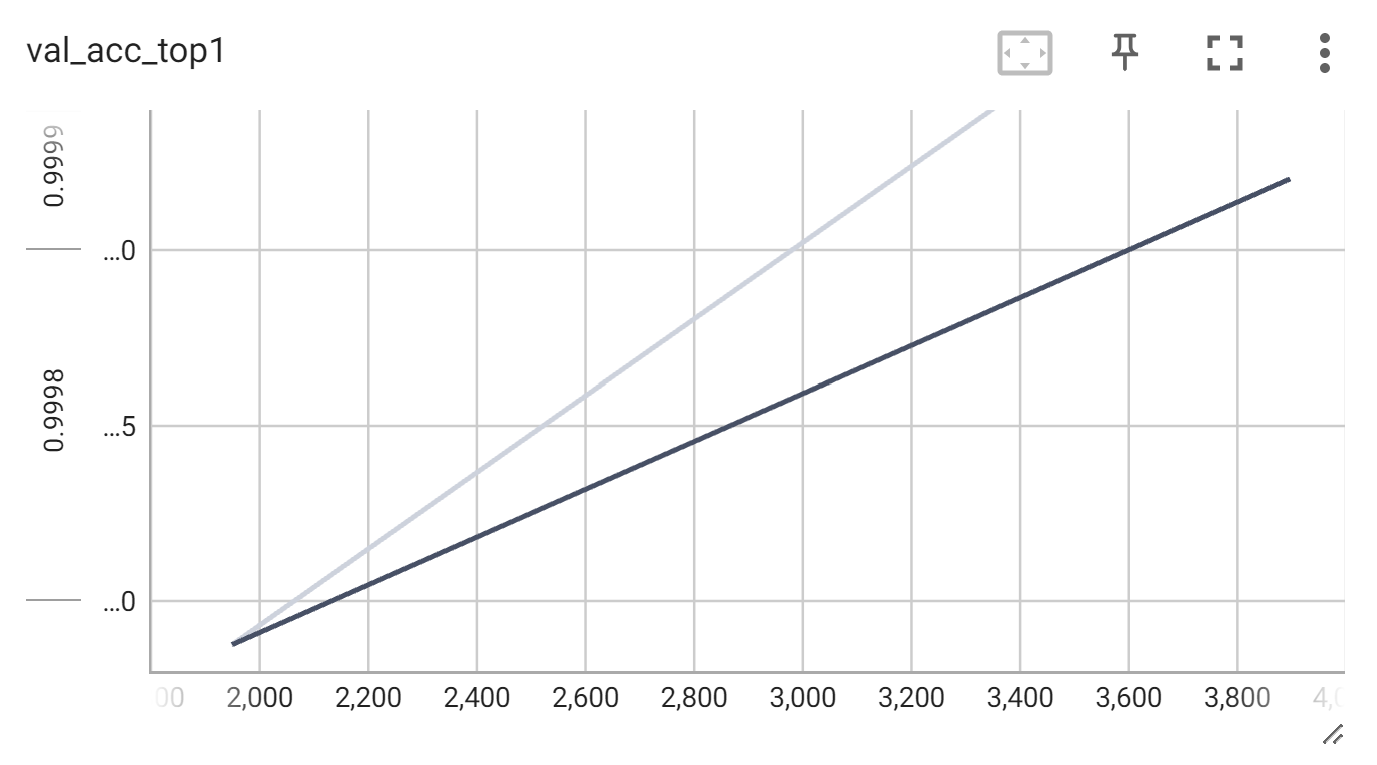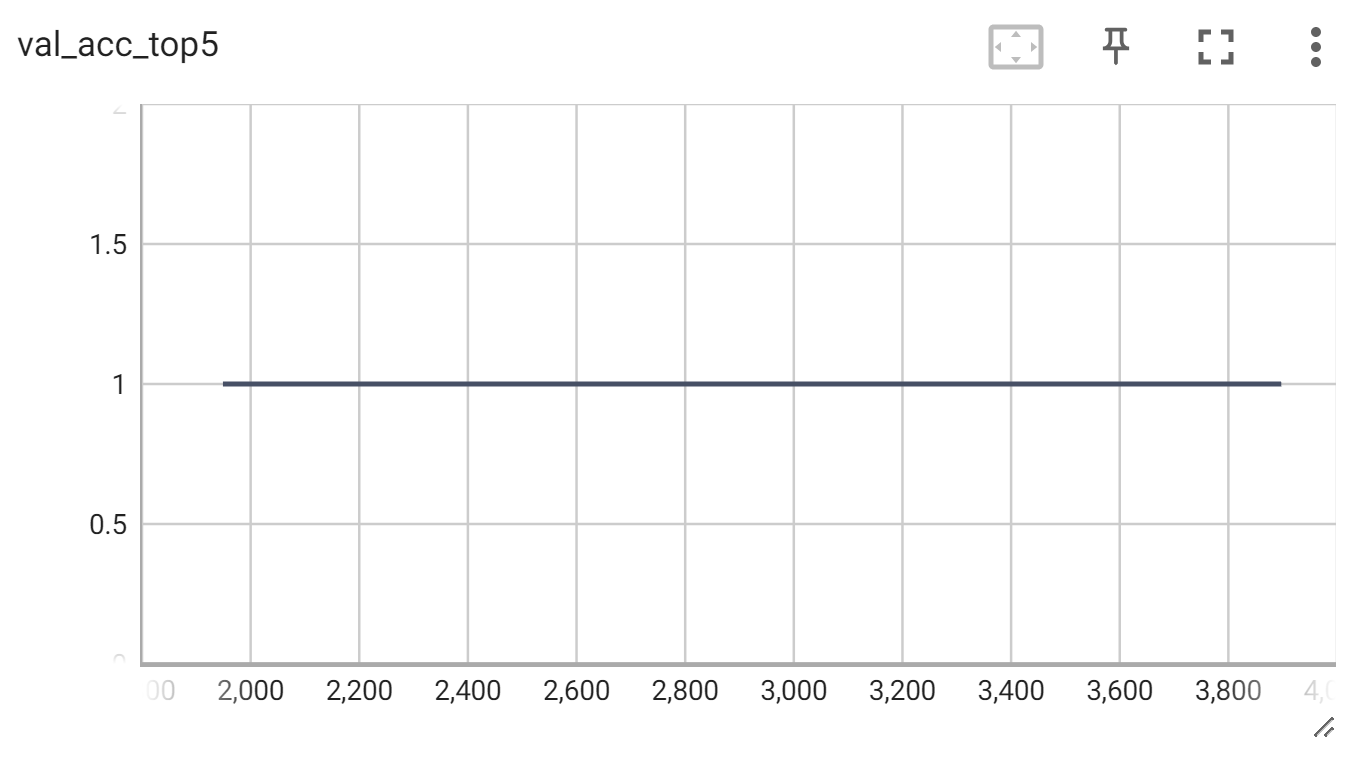

In [ ]:
@torch.no_grad()
def prepare_data_features_barlowtwins(model, dataset):
    model.eval()
    model.to(device)
    # Encode all images
    labels: list[int] = []
    feats: list[torch.Tensor] = []
    for img, label in dataset:
        img = img.to(device)
        feat = model.decoder(model.base_model(img.unsqueeze(0)))
        labels.append(label)
        feats.append(feat)

    # pdb.set_trace()
    labels = torch.Tensor(labels)
    # labels = torch.cat(labels, dim=0)
    feats = torch.cat(feats, dim=0)
    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    # Return a new dataset with the image features and labels
    return data.TensorDataset(feats.to(torch.device("cpu")), labels)

In [ ]:
train_feats_barlowtwins = prepare_data_features_barlowtwins(barlowtwins_model, train_img_data)
test_feats_barlowtwins = prepare_data_features_barlowtwins(barlowtwins_model, test_img_data)

In [ ]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    print(f"Number of Images per Label: {num_imgs_per_label}")
    train_feats_barlowtwins_reduced = get_smaller_dataset(train_feats_barlowtwins, num_imgs_per_label, 10)
    test_feats_barlowtwins_reduced = get_smaller_dataset(test_feats_barlowtwins, num_imgs_per_label, 10)
    model, small_set_results = train_logreg(
        batch_size=int(np.clip(256, 0, min((len(train_feats_barlowtwins_reduced), len(test_feats_barlowtwins_reduced))))),
        train_feats_data=train_feats_barlowtwins_reduced,
        test_feats_data=test_feats_barlowtwins_reduced,
        model_suffix=f"--BarlowTwins--n_imgs_per_label-{num_imgs_per_label}",
        feature_dim=4 * 128,
        num_classes=10,
        lr=5e-4,
        weight_decay=1e-4,
    )
    results[num_imgs_per_label] = small_set_results

In [ ]:
# Plot the results

dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    dataset_sizes,
    test_scores,
    "--",
    color="#000",
    marker="*",
    markeredgecolor="#000",
    markerfacecolor="y",
    markersize=16,
)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f"Test accuracy for {k:3d} images per label: {100*score:4.2f}%")

We can see a similar trend in this model with that of our original self-supervised model, with regards to the jumps in test accuracy as we include additional training data for our logistic regression model. We begin to see some sort of saturation, that may not be fully saturated at this point, but a bit quicker than the SimCLR model. This perhaps indicates to us that the SimCLR model is more powerful than the BarlowTwins model in this situation given the type and amount of unlabeled data to initially train on. However, the overall trend of the logistic regression model performance is similar to what we saw before, where the test accuracy increases with the more data we feed it. This model performs ~10% worse with regard to the test accuracy in comparison to the baseline model.

In [ ]:
barlowtwins_model = train_barlowtwins(batch_size=256, 
                                      model_name="BarlowTwins--500-epochs",
                                      hidden_dim=128, 
                                      lr=5e-4,  # paper set this to 0.002, but want to keep it to 5e-4 for comparison purposes
                                      weight_decay=1e-4,  # paper set this to 10e-6, but want to keep it as 1e-4 for comparison purposes
                                      lambda_=0.005,  # best result for top-1 accuracy from paper
                                      max_epochs=500)

In [ ]:
%tensorboard --logdir ../checkpoints/ece763-proj_03/BarlowTwins--500-epochs/ --port 6013

To test training our model longer, we trained the BarlowTwins model for 500 epochs. We see similar training results from training using just 10 epochs, while the loss for both the training and validation datasets appear to continuously get smaller. We see that the loss on the validation set seems to be converging to some value around 50, which looks similar to the training loss plot, however, the training loss is much noisier - indicating the training is oscillating a lot within local minimas before continuing to learn. The loss plots indicate we may be overfitting when training for so many epochs, and at a little less than 200 epochs may be the start of this overfitting according to where the training loss starts to run away from the validation loss.

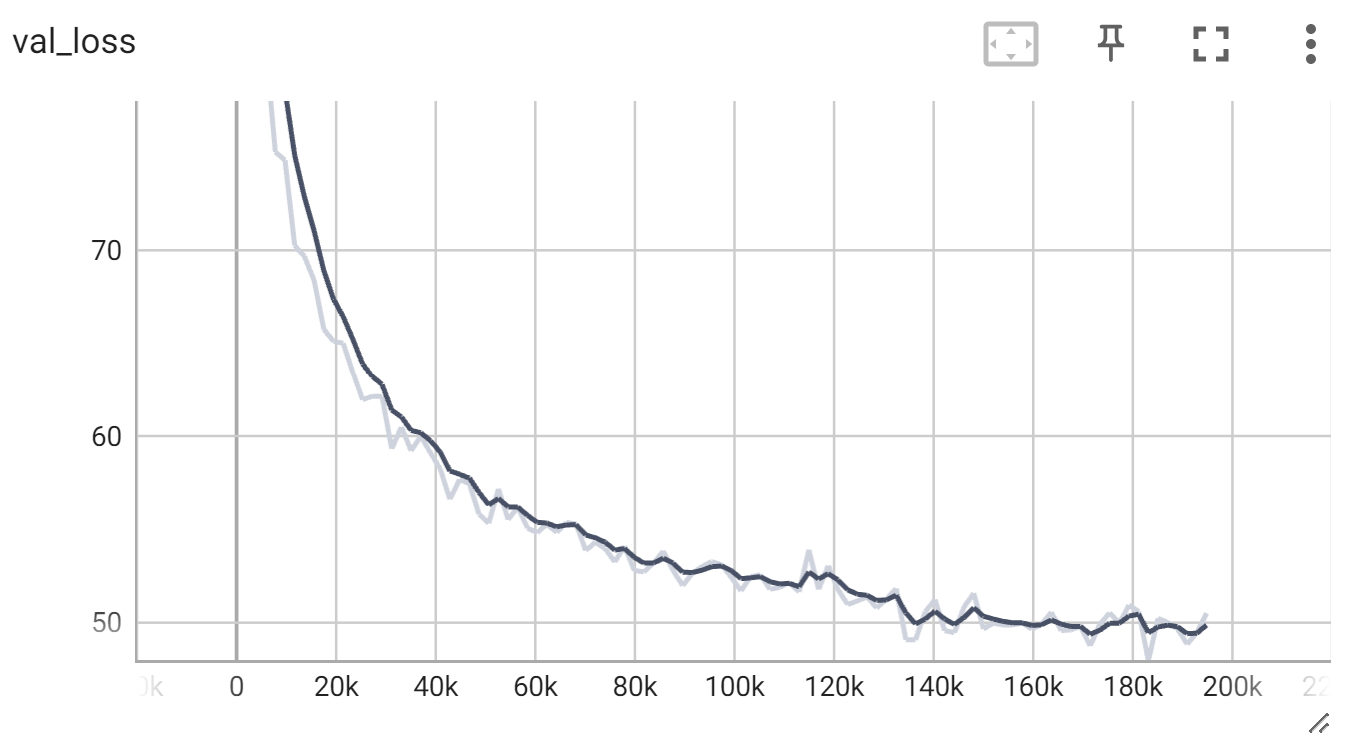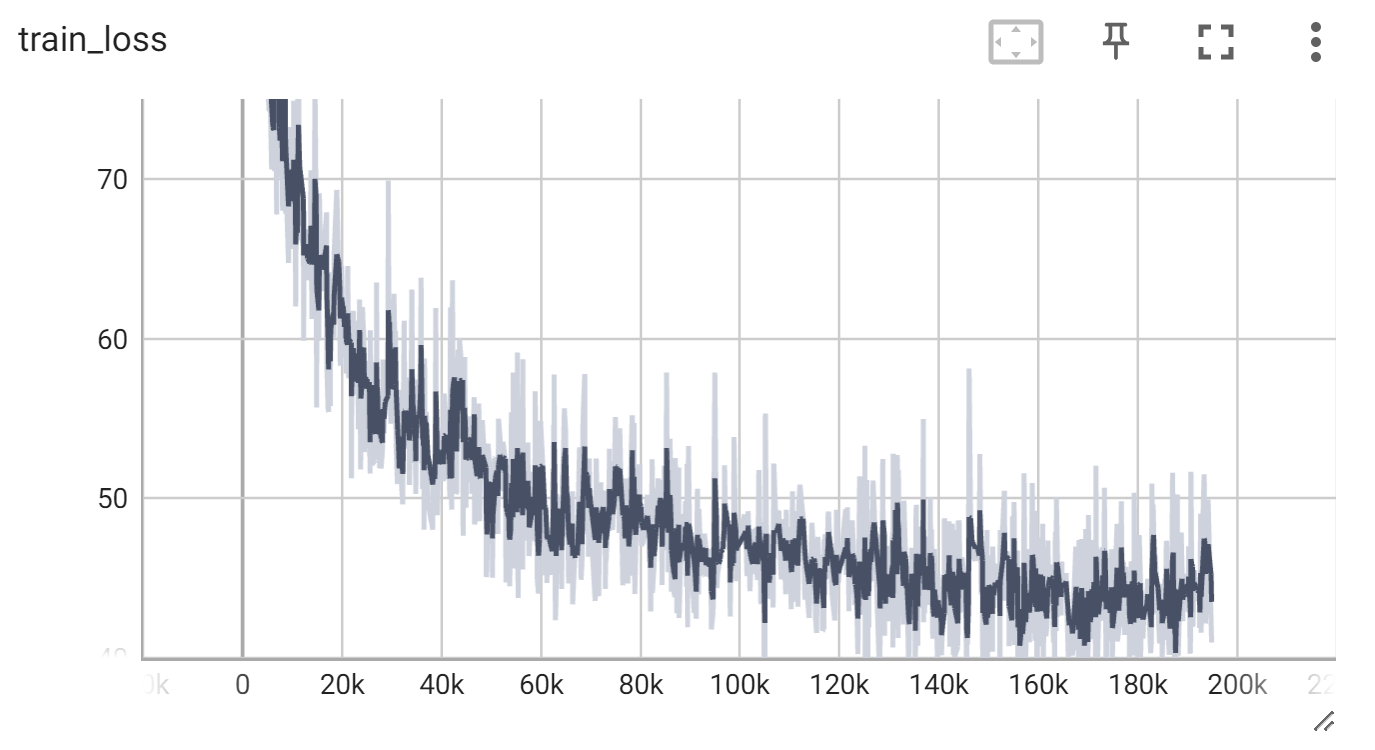

In [ ]:
train_feats_barlowtwins = prepare_data_features_barlowtwins(barlowtwins_model, train_img_data)
test_feats_barlowtwins = prepare_data_features_barlowtwins(barlowtwins_model, test_img_data)

In [ ]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    print(f"Number of Images per Label: {num_imgs_per_label}")
    train_feats_barlowtwins_reduced = get_smaller_dataset(train_feats_barlowtwins, num_imgs_per_label, 10)
    test_feats_barlowtwins_reduced = get_smaller_dataset(test_feats_barlowtwins, num_imgs_per_label, 10)
    model, small_set_results = train_logreg(
        batch_size=int(np.clip(256, 0, min((len(train_feats_barlowtwins_reduced), len(test_feats_barlowtwins_reduced))))),
        train_feats_data=train_feats_barlowtwins_reduced,
        test_feats_data=test_feats_barlowtwins_reduced,
        model_suffix=f"--BarlowTwins--n_imgs_per_label-{num_imgs_per_label}",
        feature_dim=4 * 128,
        num_classes=10,
        lr=5e-4,
        weight_decay=1e-4,
    )
    results[num_imgs_per_label] = small_set_results

In [ ]:
# Plot the results

dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    dataset_sizes,
    test_scores,
    "--",
    color="#000",
    marker="*",
    markeredgecolor="#000",
    markerfacecolor="y",
    markersize=16,
)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f"Test accuracy for {k:3d} images per label: {100*score:4.2f}%")

We can see that even with the extra training in the BarlowTwins model, we reach a very similar classification accuracy plot on the reduced datasets. Therefore, it may not be beneficial to train the model longer, but more beneficial to have a larger dataset, but we did not test this hypothesis.

# References

[1] Chen, T., Kornblith, S., Norouzi, M., and Hinton, G. (2020). A simple framework for contrastive learning of visual representations. In International conference on machine learning (pp. 1597-1607). PMLR. ([link](https://arxiv.org/abs/2002.05709))

[2] Chen, T., Kornblith, S., Swersky, K., Norouzi, M., and Hinton, G. (2020). Big self-supervised models are strong semi-supervised learners. NeurIPS 2021 ([link](https://arxiv.org/abs/2006.10029)).

[3] Oord, A. V. D., Li, Y., and Vinyals, O. (2018). Representation learning with contrastive predictive coding. arXiv preprint arXiv:1807.03748. ([link](https://arxiv.org/abs/1807.03748))

[4] Grill, J.B., Strub, F., Altché, F., Tallec, C., Richemond, P.H., Buchatskaya, E., Doersch, C., Pires, B.A., Guo, Z.D., Azar, M.G. and Piot, B. (2020). Bootstrap your own latent: A new approach to self-supervised learning. arXiv preprint arXiv:2006.07733. ([link](https://arxiv.org/abs/2006.07733))

[5] Khosla, P., Teterwak, P., Wang, C., Sarna, A., Tian, Y., Isola, P., Maschinot, A., Liu, C. and Krishnan, D. (2020). Supervised contrastive learning. arXiv preprint arXiv:2004.11362. ([link](https://arxiv.org/abs/2004.11362))

[6] Zbontar, J., Jing, L., Misra, I., LeCun, Y. and Deny, S. (2021). Barlow twins: Self-supervised learning via redundancy reduction. arXiv preprint arXiv:2103.03230. ([link](https://arxiv.org/abs/2103.03230))